# Studycat Learning from Gameplay Data Challenge

In [1]:
from sml import exp_data as ex, viz, util
import numpy as np

In [47]:
data = ex.load()
accs_data = ex.filter_accs(data)

## Product

![studycat_logo](img/studycat_logo.png)

Studycat creates mobile language learning games for children aged 3-10.
- See the website for details about the product: https://funenglish.com/.
- Trying the app will give you more of a feel for it, and what the data means: https://funenglish.com/try/

## Purpose

Our goal: **to create a personalized learning experience best suited to each learner**. We therefore want to know what contributes to good (and bad) performance. 

![personalized_learning](img/personalized_learning.png)

This means a focus on **interpretability** of results. We could try a big neural network and maybe we could get low prediction error, but that may not tell us anything useful (however it might if you design a neural network with, say, interpretable attention mechanisms).

We focus on predicting in-game accuracies on words. In general, the better you can predict these accuracies, the more your machine learning model has found what is important to predicting accuracy. So we are interested in things like what features are useful, their coefficients in linear models, etc.

## Data

This section introduces the data and features. We jump right in with a view at a data point. The sections below explain and discuss the attributes. Come back and review again once you've read the below.

```
{
 # data point id and response
 'id': 0,
 'accuracy': 0.7222222222222222,  # the response, what we are trying to predict;
                                  #   note that we calculate this from `experience`
 'subset': 'train',               # which split it belongs to, train, val, or test

 # school and student features
 'school_group': 0,               # id for the school group the user is in
 'school': 8,                     # id for the school the user is in
 'teacher': 9,                    # id for the user's teacher
 'class': 18,                     # id for the user's class
 'user': 655,                     # the user's id
 'level': 2,                      # age group, in order (so larger id is older)
 
 # game/activity features
 'score': 17,                     # game score (roughly correlates with accuracy)
 'duration': 174,                 # time to complete the game (in secs)
 'scoring_model': 30,             # id for the scoring model used in the game
 'unit_module': 117,              # id for the activity; also represents progress
                                  #   through the curriculum - larger id is further 
 'unit': 5,                       # int for the unit number of the curriculum
 'module': 11,                    # int for the module number of the curriculum
 'is_preview': False,             # whether or not the play was the user "looking ahead"
                                  #   and playing on their own (not as set homework)
 'timestamp': 1557137501073,      # when the game play occured (unix time) 
 'vocab_groups': ['numbers'],     # the kind of vocab seen in this game
 'words': ['one', 'two',...],     # list of all words/phonemes/letters seen in this game.
 'experience': [                  # list of all experiences of words in this game
  {'type': 'exposure',            # the type of experience, in {exposure, question}
   'game_time': 0,                # the time from the start of the game when this occurred
   'word': 'letters_x'},          # the word experienced or questioned
  # the absence of `mistake` in this one means they got it right
  {'type': 'question',            # this was a tested word
   'response_time': 2.4,          # `s` gives the response time - how long from question to answer
   'game_time': 12.4, 
   'word': 'letters_y'},
  {'type': 'question', 
   'response_time': 1.6, 
   'mistake': 'letters_s',        # `m` means a mistake and the value is which word was selected instead
   'game_time': 81.1, 
   'word': 'letters_x'},
  ...],
 }
```

### Response (or Dependent Variable)

We want to predict the **accuracy** achieved in each activity. This is different from score. During an activity a student may be asked to pick the right word/letter/phoneme from a set of choices. If so we count how many they got right and divide by the total number of questions.

For example, in this game the students might be tested on the vocab: "on," "under," etc.

![game_example](img/game_example.png)

Note that some records don't have accuracies. Some activities just have "exposures" to the language, without testing whether they know it. We have included this data because it is likely it will be important for the task. For example, if I ask you just after class about what you learned you are more likely to remember than three weeks later.

The preponderance of accuracies in the data:

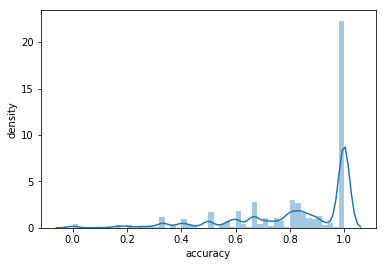

In [8]:
viz.dist(accs_data, 'accuracy')

### Schools, Teachers, Classes

We currently have around 2,000 students using the school-based app every day, for over half a year. It is their gameplay data we are using in what we describe below.

The come from two **school-groups**, which in turn have one or more **schools**. Predictably, schools have one or more **teachers**, which have **classes**, which have our **students**. In diagram form:

![entity_hierarchy](img/entity_hierarchy.png)

The following plots show that teacher, class, etc can effect student performance.

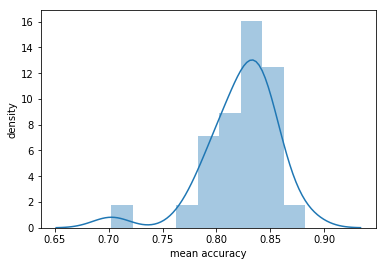

In [10]:
viz.mean_accs(accs_data, 'teacher')

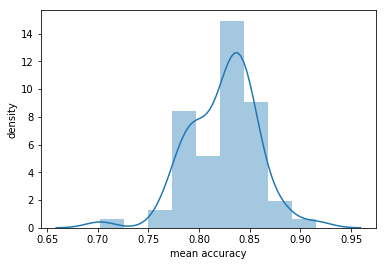

In [11]:
viz.mean_accs(accs_data, 'class')

And student performance is not even - looks almost normally distributed, though a bit skewed toward better performance.

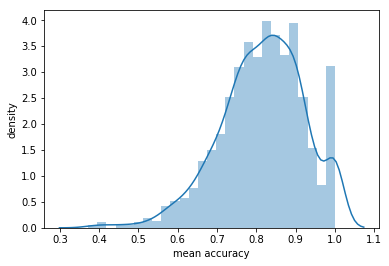

In [12]:
viz.mean_accs(accs_data, 'user')

### Levels

The classes are divided into three levels that correspond to age groups. These are numerically coded in the data in order. So we should expect a little correlation with this feature and accuracy:

In [40]:
for level in range(3):
    print('Mean accuracy at age group %s: %s' % (level, np.mean([x['accuracy'] for x in accs_data 
                                                                 if x['level'] == level])))

Mean accuracy at age group 0: 0.8081025514497924
Mean accuracy at age group 1: 0.8312675943576393
Mean accuracy at age group 2: 0.8329055518368786


### Curriculums

The product is for **schools**. It follows a **curriculum**. The curriculum is made up of **modules** (or lessons) that have games (or activities). Modules beong to **units**. Here is an example:

![curriculum_example](img/curriculum_example.png)

This module has 5 activities (4 games and a quiz).

The unit-modules are represented by integers in our data. They can be taken as an ordinal value representing progress through the curriculum. We see the distribution over accuracies over unit-modules is not even:

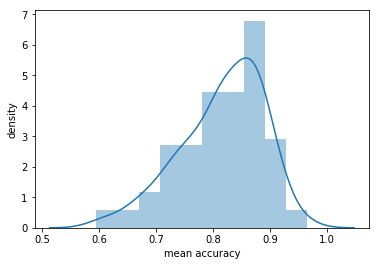

In [17]:
viz.mean_accs(accs_data, 'unit_module')

There is a temporal trend in the data, with accuracy changing in a particular way as a function of progress through the curriculum. This is likely explained by the addition of newer, harder material as the course progresses.

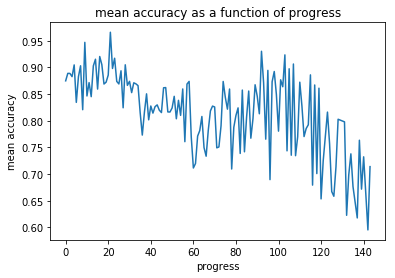

In [22]:
viz.progress_and_accuracy(accs_data)

### Scoring Models

Different types of game have different scoring models. Since in this task we're not concerned about scores, we can use this feature to represent "game type". There are some differences in accuracies over game types:

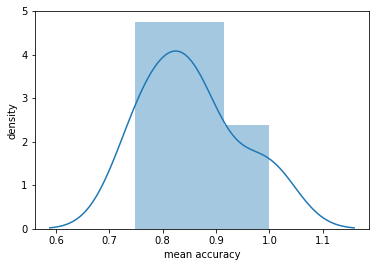

In [26]:
viz.mean_accs(accs_data, 'scoring_model')

### Preview Plays

When a student "preview" plays, they play games with language they have not yet learned in class. It is not surprising that the mean accuracy for these games is lower.

In [27]:
np.mean([x['accuracy'] for x in accs_data if x['is_preview']])

0.7778832611236686

In [28]:
np.mean([x['accuracy'] for x in accs_data if not x['is_preview']])

0.8481263851977003

## Dataset Size

In [35]:
print('Full dataset size: %s' % len(data))
print('Accuracies dataset size: %s' % len(accs_data))

Full dataset size: 447497
Accuracies dataset size: 172619


### Train/Dev/Test Split

Binning data points into time blocks, we first check the evolution of average score over time.

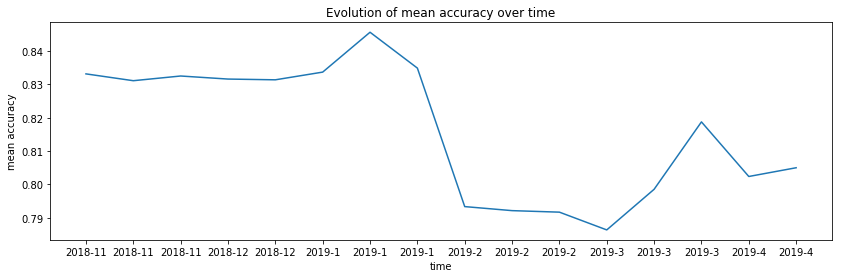

In [33]:
viz.acc_over_time(accs_data, days=10)

This tells us if we take a subset from the end of the data as our test set, it will have a different distribution to the training set, and machine learning will struggle.

We therefore split our train-val-test sets on **users**. This allows whatever preprocessing techniques are used on a per-user basis to be appropriate for application to all sets without invalidating the results, and keeping the distributions as equal as possible.

In the end the dataset sizes are:

In [48]:
# for full dataset
print('Number train data points: %s' % len([x for x in data if x['subset'] == 'train']))
print('Number val data points: %s' % len([x for x in data if x['subset'] == 'val']))
print('Number test data points: %s' % len([x for x in data if x['subset'] == 'test']))

Number train data points: 392805
Number val data points: 29740
Number test data points: 24952


In [49]:
# for just activities with accuracies
print('Number train data points: %s' % len([x for x in accs_data if x['subset'] == 'train']))
print('Number val data points: %s' % len([x for x in accs_data if x['subset'] == 'val']))
print('Number test data points: %s' % len([x for x in accs_data if x['subset'] == 'test']))

Number train data points: 151508
Number val data points: 11671
Number test data points: 9440


## Suggestions

The features we include in our baselines are by no means the best. Most importantly we are missing anything about the student's history, the time between the last test or exposure, and any features that might indicate a student's ability.

Here we make some concrete suggestions for things to look at to try and help you.

### Rate of Forgetting

Researchers have found a "rate of forgetting" that should look something like this

![rate_of_forgetting](img/rate_of_forgetting.png)

[Wikipedia](https://en.wikipedia.org/wiki/Forgetting_curve) has a simpler formula for version of this:

$$
R = e^{-\frac{t}{S}}
$$

where $R$ is how easy it is to remember something, and $S$ is how stable memory is. It is very likely trying to use something like this will be very useful for our data - can we fit $S$ parameters for all of our students? What would the distribution be like? Normal? Would there be clusters?

### Statistical Dependences

We attempted to think through what we think are statistical dependencies in the data, and included some latent variables we expect might help explain the data. We've expressed it as a Bayesian network. 

The way to read this is as follows. The directed edges express statistical dependency. An in edge means the node depends on its parent (what is going into it). Grey nodes are variables we observe. White nodes are unobserved (posited) latent variables.

![bayesian_network](img/bayesian_network.png)

This is not complete and probably needs updating. We present it here as an example of some things that might be important, to try and give you some suggestions for what to do next.

### Other Ideas

- Maybe the day of the week, or weekend versus weekday has signal? Maybe not.
- Maybe word groups are important
  * the prior probability of getting numbers right could be higher than sea animals
  * some students might be visual learners and do better with pictures (e.g. animals) as opposed to letters/phonics